In [1]:
import keras
keras.__version__

Using TensorFlow backend.
/home/sasaki/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sasaki/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sasaki/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sasaki/.local/lib/python3.6/site-packages/tensorflow/python

'2.3.1'

In [3]:
import os

data_dir = '/home/sasaki/Downloads/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [4]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

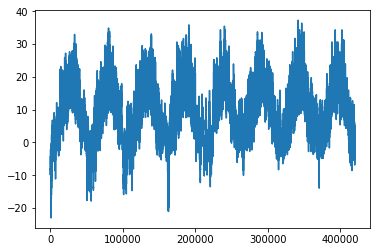

In [6]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

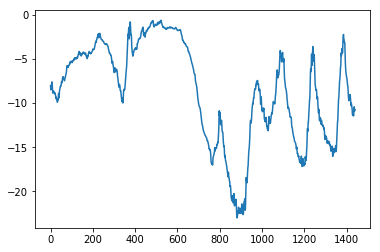

In [7]:
plt.plot(range(1440), temp[:1440])
plt.show()

In [8]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [9]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [10]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [11]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


In [13]:
celsius_mae = 0.2897359729905486 * std[1]
print(celsius_mae)

2.564887434980494


In [14]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)


Epoch 1/20
500/500 [==============================] - 16s 32ms/step - loss: 1.4074 - val_loss: 0.5560
Epoch 2/20
500/500 [==============================] - 16s 31ms/step - loss: 0.4048 - val_loss: 0.2484
Epoch 3/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2873 - val_loss: 0.2491
Epoch 4/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2658 - val_loss: 0.2781
Epoch 5/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2529 - val_loss: 0.3448
Epoch 6/20
500/500 [==============================] - 16s 31ms/step - loss: 0.2471 - val_loss: 0.3190
Epoch 7/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2394 - val_loss: 0.4166
Epoch 8/20
500/500 [==============================] - 16s 31ms/step - loss: 0.2334 - val_loss: 0.3127
Epoch 9/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2287 - val_loss: 0.3694
Epoch 10/20
500/500 [==============================] - 16s 32ms/step - loss: 0.22

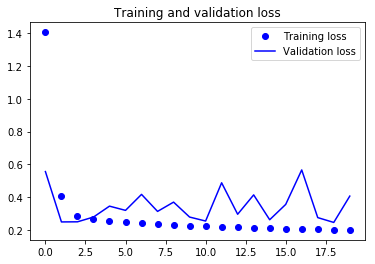

In [15]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 142s 283ms/step - loss: 0.3076 - val_loss: 0.1199
Epoch 2/20
500/500 [==============================] - 126s 252ms/step - loss: 0.2840 - val_loss: 0.1192
Epoch 3/20
500/500 [==============================] - 124s 249ms/step - loss: 0.2774 - val_loss: 0.1637
Epoch 4/20
500/500 [==============================] - 125s 249ms/step - loss: 0.2725 - val_loss: 0.1328
Epoch 5/20
500/500 [==============================] - 124s 248ms/step - loss: 0.2697 - val_loss: 0.1337
Epoch 6/20
500/500 [==============================] - 124s 248ms/step - loss: 0.2649 - val_loss: 0.1298
Epoch 7/20
500/500 [==============================] - 123s 247ms/step - loss: 0.2609 - val_loss: 0.1216
Epoch 8/20
500/500 [==============================] - 123s 247ms/step - loss: 0.2569 - val_loss: 0.1349
Epoch 9/20
500/500 [==============================] - 136s 272ms/step - loss: 0.2531 - val_loss: 0.1107
Epoch 10/20
500/500 [==============================] - 155s 310m

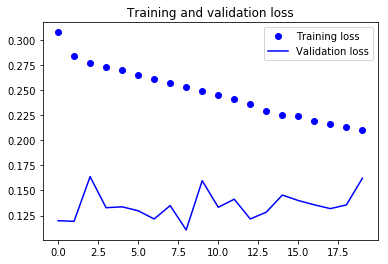

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()